In [1]:
from pylab import *
colormap='Greys_r'

cmap = cm.get_cmap(colormap, 13)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy import units as u
from tqdm import tqdm_notebook
from astropy import constants
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.nddata import CCDData
import ccdproc as ccdp
from astropy.time import Time
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.ndimage import percentile_filter
from astropy import units

import starry
starry.config.lazy = False
starry.config.quiet = True

import warnings
warnings.filterwarnings("ignore")

COLOR='black'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9

datadir = '/Users/arcticfox/Downloads/gemini_data'

TIME = Time(np.load(os.path.join(datadir, 'mjddates.npy')), format='mjd')
barycorr = np.load(os.path.join(datadir, 'barycorr.npy')) * u.km / u.s

lines = Table.read(datadir + '_2021/fraunhofer.txt', format='ascii')

parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [2]:
planet_d_per = 12.403200
planet_c_per = 8.249580

planet_c_dur = (4.66*u.hour).to(u.day).value
planet_d_dur = (5.59*u.hour).to(u.day).value

planet_c_t0 = 2458846.097156# - 2400000
planet_d_t0 = 2458845.803649# - 2400000

In [3]:
import batman 

def batman_model(time, vals):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = vals[0]                       #time of inferior conjunction
    params.per = vals[1]                       #orbital period
    params.rp = vals[2]                       #planet radius (in units of stellar radii)
    params.a = vals[3]                        #semi-major axis (in units of stellar radii)
    params.inc = 89.                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [vals[4], vals[5]]     #limb darkening coefficients [u1, u2, u3, u4]

    m = batman.TransitModel(params, time)    #initializes model
    return m.light_curve(params)

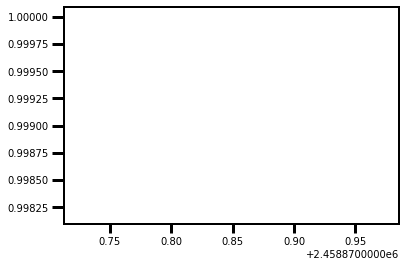

In [4]:
planetc_params_new = [planet_c_t0, 8.24958, 0.0381, 13.19, 0.591, 0.098]
jdtime = Time(TIME, format='mjd').jd
battime = np.linspace(jdtime[0], jdtime[-1], len(jdtime))

c_lightcurve_new = batman_model(battime, planetc_params_new)
plt.plot(battime, c_lightcurve_new, 'wo')
yphase = np.zeros(len(c_lightcurve_new))
yphase[c_lightcurve_new==1.0] = np.nan

args = np.where(np.isnan(yphase)==False)[0]
yphase[args] = np.linspace(0, 1.0, len(args))
#plt.plot(battime, yphase+0.5)

In [5]:
fitsfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if i.endswith('.fits')])
#TIME = np.zeros(len(fitsfiles))

for i in range(len(fitsfiles)):
    hdu = fits.open(fitsfiles[i])
#    TIME[i] = hdu[0].header['MJDATE']
    hdu.close()
    
#len(TIME), planet_c_t0+planet_c_per*3-planet_c_dur/2

In [6]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [7]:
wavefiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'wavelength_order_' in i and i.endswith('.npy')])
specfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'spectra_order_' in i and i.endswith('.npy')])
specfiles

array(['/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_03.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_04.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_10.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_11.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_15.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_18.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_21.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_25.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_26.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_27.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_28.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_29.npy',
       '/Users/arcticfox/Downloads/gemin

In [8]:
wavelengths = {}
spectra = {}
for i in range(len(wavefiles)):
    index = int(specfiles[i].split('.')[0][-2:])
    subtab = lines[lines['index'] == index]
    wdat = np.load(wavefiles[i], allow_pickle=True)
    sdat = np.load(specfiles[i], allow_pickle=True)
    for key in subtab['line']:
        wavelengths[key] = wdat
        spectra[key] = sdat
#spectra = np.load('interp_1d_spectra.npy')

In [9]:
def subregions(location, w, offsets, offset_line, feature=None):
    global TIME
    #print(w)
    #print(np.where( (w>=location-offsets[0]) & (w<=location+offsets[1])))
    #print(offsets)
    whole_region = ((w>=location-offsets[0]) & 
                    (w<=location+offsets[1]))

    line = ((w[whole_region]>=location-offset_line[0]) & 
            (w[whole_region]<=location+offset_line[1]))

    
    if feature != 'na' and feature != 'mgb4':
        continuum = np.where((line==False))[0]
    elif feature == 'na':
        continuum = np.where( ( (w>=587.5)  & (w<=588.6) ) |
                              ( (w>=590.0)  & (w<=591) ) )[0]
    elif feature == 'mgb4':
        continuum = np.where( ( (w) ))
    
    params = {'location': location,
              'region': whole_region,
              'line': line,
              'continuum': continuum}
        
    return params

In [10]:
def measure_excess(wavelength, spectra, params, tab):
    global TIME, out_args
    
    widths = np.zeros(len(TIME))

    #wave = wavelengths[:,tab['index'],:]
    #spec = spectra[:,tab['index'],:]
    
    lines = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']])))#[params['line']])))
    waves = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']])))#[params['line']])))
    new_spec = np.zeros((len(TIME),
                        len(wavelength[0][params['region']])))
    
    for i in range(len(TIME)):

        w, f = wavelength[i][params['region']]+0.0, spectra[i][params['region']]+0.0
        
        interp = np.polyfit(w[params['line']==False],
                            f[params['line']==False], 
                            deg=2)
        model = np.poly1d(interp)

        new_spec[i] = f / model(w)
        
    template_out = np.nanmedian(new_spec[out_args], axis=0)

    for i in range(len(new_spec)):
        ## CALCULATE EXCESS ABSORPTION
        divout = new_spec[i]/template_out
        mask = np.where(divout < np.nanmedian(divout)+2.5*np.nanstd(divout))[0]
        widths[i] = np.nansum((new_spec[i][mask]/template_out[mask]) - 1) * -1       
        lines[i] = new_spec[i]#[params['line']]
        waves[i] = wavelength[i][params['region']]#[params['line']]
        plt.plot(w[mask], new_spec[i][mask], 'k')
        
        #plt.plot(w[mask][params['line']], f[mask][params['line']])
        
    plt.plot(w, template_out, 'w')
    plt.axvspan(w[params['line']][0], w[params['line']][-1], 
                    color='darkorange', alpha=0.3)
    #plt.axvspan(w[params['continuum']][0], w[params['continuum']][-1], 
    #                color='skyblue', alpha=0.4, zorder=1)
    plt.ylim(np.nanmin(f[mask])-0.01, 
             np.nanmax(new_spec[i][mask])+0.01)
    plt.show()
    
    return widths, lines, waves

- sodium as doublet as a single feature (✓)
- Mg lines (x)
- h-beta line (x)
- FeII - 546.6 (✓)
- Li - 680.3 (✓)
- He - 587.5618

In [11]:
out_args = np.where(np.isnan(yphase)==True)[0]
out_args

array([ 0,  1,  2,  3,  4, 47, 48, 49, 50, 51, 52])

Text(0.5, 0, 'Wavelength [nm]')

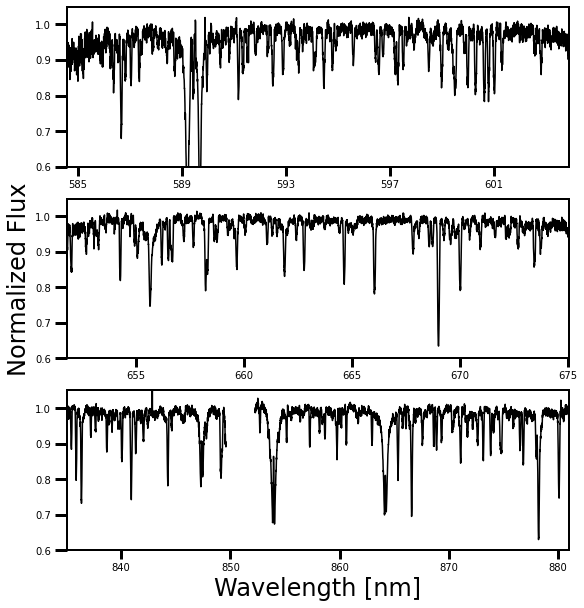

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9,10),
                                    sharey=True)

hind = 20
ax2.plot(wavelengths['halpha'][hind], spectra['halpha'][hind], 'k')
ax2.set_xlim(wavelengths['halpha'][hind][10], wavelengths['halpha'][hind][-10])

ax3.plot(wavelengths['caII'][15][10:], spectra['caII'][15][10:], 'k')

ax3.plot(wavelengths['caI'][15], spectra['caI'][15], 'k')
ax3.set_xlim(835,881)


nind = 51
q = spectra['NaD'][nind] < 1.02
ax1.plot(wavelengths['NaD'][nind][q], spectra['NaD'][nind][q], 'k')
ax1.set_xlim(wavelengths['NaD'][nind][10], wavelengths['NaD'][nind][-10])
ax1.set_xticks(np.arange(585, 603, 4))

plt.ylim(0.6,1.05)
plt.subplots_adjust(wspace=0.1)

ax2.set_ylabel('Normalized Flux', fontsize=24)
ax3.set_xlabel('Wavelength [nm]', fontsize=24)

#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'example_spectra.pdf'), 
#            rasterize=True, bbox_inches='tight',
#            dpi=300)

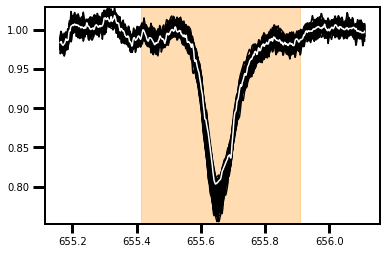

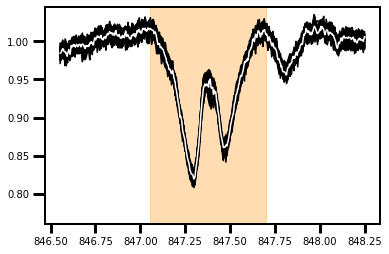

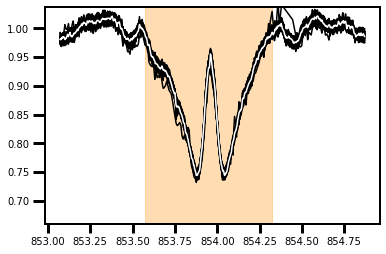

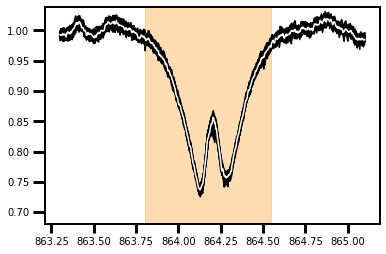

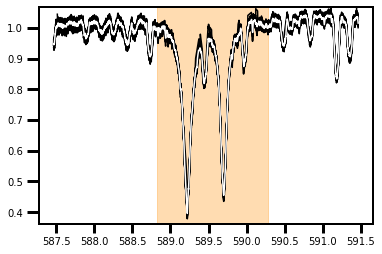

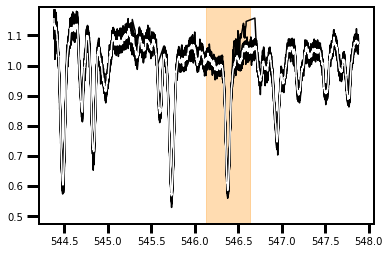

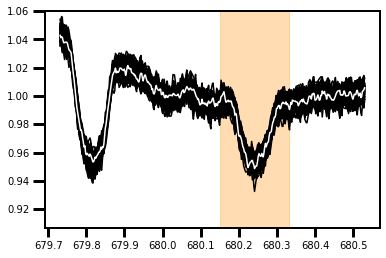

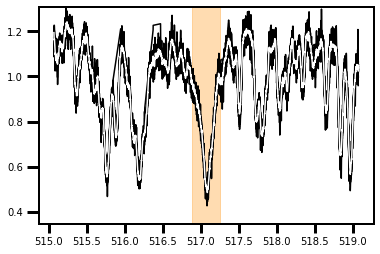

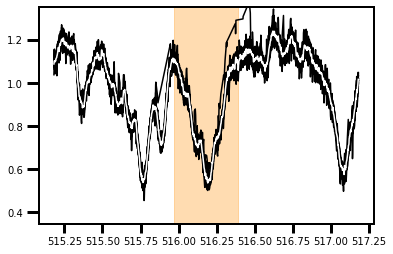

In [13]:
l = 3
offsets = [[0.55,0.4], 
           [0.85,0.85], [0.9,0.9], [0.9,0.9],
           [2,2], 
           [2,1.5], [0.5,0.3], [2,2],
           [1,1], [1,1]]

line_offsets = [[0.3,0.2], 
                [0.35,0.3], [0.4,0.35], [0.4,0.35],
                [0.65,0.82], 
                [0.25,0.25], [0.08,0.1], [0.18,0.18],
                [0.21,0.21], [0.1,0.1]]
widths = {}
ind_lines = {}
ind_waves = {}
all_params = {}

for l in range(len(lines)):
    key = lines['line'][l]
    params = subregions(lines['wavelength'][l], 
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)
    all_params[key] = params 

    w, il, iw = measure_excess(wavelengths[key], spectra[key], 
                               params, lines[l])

    widths[lines['line'][l]] = w

    ind_lines[lines['line'][l]] = il
    ind_waves[lines['line'][l]] = iw

## Error bars

In [15]:
files = np.sort(os.listdir(os.path.join(datadir, 'reduced')))
files = np.sort([os.path.join(os.path.join(datadir, 'reduced'), i) for i in files])

In [16]:
len(files), datadir

(53, '/Users/arcticfox/Downloads/gemini_data')

In [17]:
i = 0
ORDER_START = 23

interp_std = {}

for j in range(len(lines)):
    key = lines['line'][j]
    
    for i in range(len(files)):
        hdu = fits.open(files[i])
        o = hdu[0].data[0] == ORDER_START+lines['index'][j]

        if i == 0:
            std = np.zeros((len(files), len(hdu[0].data[11][o])))
        
        try:
            std[i] = np.sqrt(hdu[0].data[11][o])
        except ValueError:
            std[i] = np.sqrt(hdu[0].data[11][o][:len(std[0])])

    iv = np.zeros(wavelengths[key].shape)
        
    for i in range(len(std)):
        mod = interp1d(hdu[0].data[4][o][:len(std[0])], std[i])
        iv[i] = mod(wavelengths[key][i])

    interp_std[key] = iv*np.sqrt(3)
    
    if j != len(lines)-1:
        hdu.close()

## Comparing to Veloce

In [286]:
from astropy.table import Column

In [287]:
table = Table.read('/Users/arcticfox/Documents/youngStars/veloce/spectra/updated_log.tab',
                   format='ascii')
table = table[table['overlapping']==0]
ages = np.zeros(len(table))
which_age = [25, 150, 150, 150, 25]
for i,t in enumerate(np.unique(table['TIC'])):
    args = np.where(table['TIC']==t)[0]
    ages[args] = which_age[i]
table.add_column(Column(ages, 'Ages_Myr'))

In [288]:
veloce_times = Time(table['time_mjd'], format='mjd')
len(veloce_times)

164

In [289]:

bins = np.arange(-12,12,1)
pink = '#c30758'
blue = parula_colors[80]

def plot_hist(ax, dat, bins, c, label, alpha=0.65, lw=2.5, histtype='step'):
    ax.hist(dat, bins=bins,
            color=c, 
            alpha=alpha, label=label)

    ax.hist(dat, bins=bins,
            edgecolor=c, fill=None, histtype=histtype,
            lw=lw)#, label=label)
    return

oc = colors[6]#parula_colors[10]#parula_colors[60]#'#e0db45'
vc = parula_colors[5]
yc = colors[1]#colors[1]#'#f2c708'#'#c30758'#

In [290]:
bins

array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11])

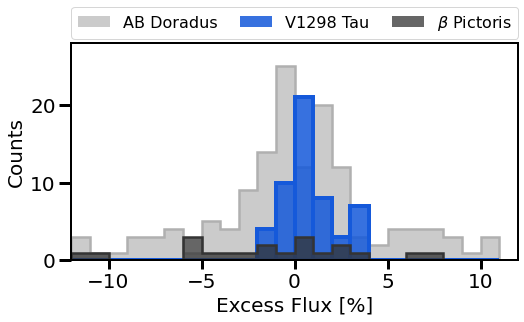

In [304]:
from scipy.stats import norm
old_tab = table[table['Ages_Myr']==150]
yng_tab = table[table['Ages_Myr']==25]
xd = np.linspace(-12,12,500)

fig, ax = plt.subplots(figsize=(8,4))

np.random.seed(124)
#density = sum(norm(xi).pdf(xd) for xi in old_tab['excess'])
#plt.fill_between(xd, density,  color=colors[8], label='AB Doradus')
plot_hist(ax, old_tab['excess'],  bins, colors[7], 'AB Doradus', alpha=0.65,
          lw=2.5)

#density = sum(norm(xi).pdf(xd) for xi in widths['halpha'])
#plt.fill_between(xd, density, alpha=0.85, color='#3550fe')#parula_colors[5])
plot_hist(ax, widths['halpha'],  bins, parula_colors[27], 'V1298 Tau', alpha=0.85,
          histtype='bar', lw=4)

#density = sum(norm(xi).pdf(xd) for xi in yng_tab['excess'])
#plt.fill_between(xd, density,  color=colors[2], zorder=10, label=r'$\beta$ Pictoris')
plot_hist(ax, yng_tab['excess'],  bins, colors[2], r'$\beta$ Pictoris', alpha=0.75,
          lw=2.5)

plt.xlim(-12,12)
plt.ylim(0,28)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Excess Flux [%]')
plt.ylabel('Counts')

plt.savefig(os.path.join(plot_dir,'veloce_diff.pdf'), dpi=200,
            rasterize=True, bbox_inches='tight')

In [ ]:
parula_colors[220]

### To-Do List

- **do the same for the veloce data --> measure halpha emission in excess**
- **run elsa's star on one night**
- **run for the rest of the Fraunhofer lines** --> https://en.wikipedia.org/wiki/Fraunhofer_lines
- **e R r O r    B a R s**
    - OPERA pipeline error bars: what do they look like? (✓)
    - Estimate scatter around the line and take that as the uncertainty
- **Cool to do: combine the lines (straightforward in velocity space?)**

### To-Done List

- run for some telluric line and demonstrate we don't see the same thing (✓)
- do the same waterfall plot with just halpha (✓)
- normalize halpha depth to be the same (✓)
    - similar to what we did for veloce emission
- rerun without final 6 frames (✓)
- calcium triplet -- if it's flat we're good. if it isn't we need to fear the spot (✓)

To Trevor, Marshall and cc'ed Ben:
think we see signal in individual lines, but overall, the average line profile is being dominated by stellar activity in a way that's washing everything out. so we don't see anything that's jumping out. so we're leaning towards fraunhofer lines. does that seem like a reasonable approach?

In [18]:
from matplotlib.colors import LinearSegmentedColormap

clist = np.array(['#000000', parula_colors[60], '#FFFFFF',
                  
                  ])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

In [19]:
def expanding_bins(lines, repeat=3, subtract=True):
    global TIME
    
    med = np.nanmedian(lines, axis=0)
    binned = np.zeros( (len(TIME)*repeat, len(lines[0]))  )
            
    z = 0
    for i in range(len(lines)):
        if subtract == True:
            binned[z:z+repeat] = lines[i] - med
        else:
            binned[z:z+repeat] = lines[i]
        z += repeat
    return binned, med

In [20]:
def normalizing_depth(wave, spectra, plot=False, reg=[655.6,655.75]):
    normalized = np.zeros(spectra.shape)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i,flux in enumerate(spectra):
        
        region = ((wave[i]>=reg[0]) & (wave[i]<=reg[-1]))

        norm_around_zero = flux - np.nanmedian(flux[~region])
        area = np.trapz(norm_around_zero[region], wave[i][region])
        normalized[i] = norm_around_zero/np.abs(area)
        
        if plot:
            ax1.plot(wave[i], flux, c=parula_colors[i*4])
            ax2.plot(wave[i], norm_around_zero / np.abs(area),
                     c=parula_colors[i*4])
            
    if plot:
        plt.show()
    return normalized

In [21]:
halpha_normalized = normalizing_depth(ind_waves['halpha'], ind_lines['halpha'])

In [22]:
def to_velocity(wave, line=None):
    if line != None:
        argmid = np.where(wave>=line)[0][0]
    else:
        argmid = int(len(wave)/2)
    lambda0 = wave[argmid] + 0.0
    rv_m_s = ((wave - lambda0)/lambda0 * 3e8)*units.m/units.s
    rv_km_s = rv_m_s.to(u.km/u.s)
    return rv_km_s, argmid

Text(0, 0.5, 'Normalized Spectra')

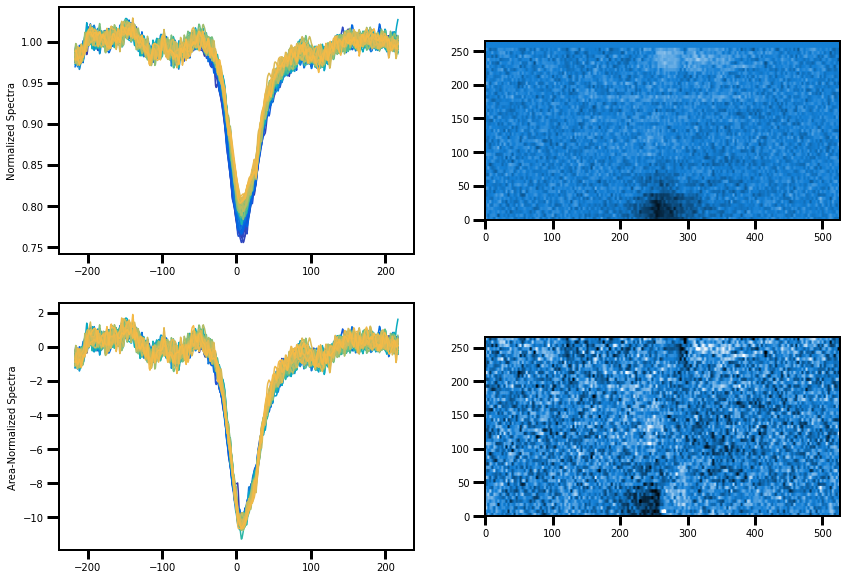

In [23]:
fig, ((ax3, ax1), (ax4, ax2)) = plt.subplots(ncols=2, nrows=2,
                                             figsize=(14,10))
for i in range(2,len(ind_lines['halpha'])):
    vel,_ = to_velocity(ind_waves['halpha'][i])
    
    ax3.plot(vel, ind_lines['halpha'][i], c=parula_colors[i*4])
    ax4.plot(vel, halpha_normalized[i-2], c=parula_colors[i*4])

bins, temp = expanding_bins(ind_lines['halpha'][2:], repeat=5)
ax1.imshow(bins, cmap=cm, vmin=-0.05, vmax=0.05)

bins, temp = expanding_bins(halpha_normalized, repeat=5)
ax2.imshow(bins, cmap=cm, vmin=-1, vmax=1)

ax2.set_ylim(0,len(bins))
ax1.set_ylim(0,len(bins))
ax4.set_ylabel('Area-Normalized Spectra')
ax3.set_ylabel('Normalized Spectra')

#plt.savefig(os.path.join(plot_dir, 'halpha_compare.png'), dpi=200, rasterize=True,
#            bbox_inches='tight')

In [24]:
def mask_lines(w, s, std=2.5, offset=0.007, template_inds=None):

    if type(template_inds) == np.ndarray:
        template = np.nanmedian(s[template_inds], axis=0)
    else:
        template = np.nanmedian(s, axis=0)

    newwave = np.zeros((len(w), len(s[0])-1))
    newspectra = np.zeros((len(w), len(s[0])-1))
    
    for i in range(len(w)):
        
        deriv = 0.5*(np.diff(s[i]))
        mask = np.where( (deriv>=offset) | 
                         (deriv<=-offset) )

        masked_w, masked_s = w[i][1:]+0.0, s[i][1:]+0.0
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
        
        divout = masked_s/template[1:]
        mask = np.where(divout>np.nanmedian(divout)+std*np.nanstd(divout))
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
       #plt.plot(masked_w[mask], masked_s[mask], 'y.')
        
        newwave[i] = masked_w
        newspectra[i] = masked_s

    return newwave, newspectra

In [25]:
plot_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures'

In [26]:
time_to_phase = interp1d(TIME.value, yphase)
phase_to_time = interp1d(yphase, TIME.value)

midtime = phase_to_time(0.5)
halfdur = planet_c_dur / 2.0
t1 = time_to_phase(midtime-halfdur)#, time_to_phase(midtime+halfdur)

ingress_time = (4.66-4.26)/2.0
egress_time = 4.66-ingress_time

interp_time = interp1d(np.linspace(0,4.66,len(yphase[np.isnan(yphase)==False])),
                       yphase[np.isnan(yphase)==False])
ingress_phase = interp_time(ingress_time)
egress_phase = interp_time(egress_time)

In [27]:
list(ind_lines.keys())

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2', 'mgb4']

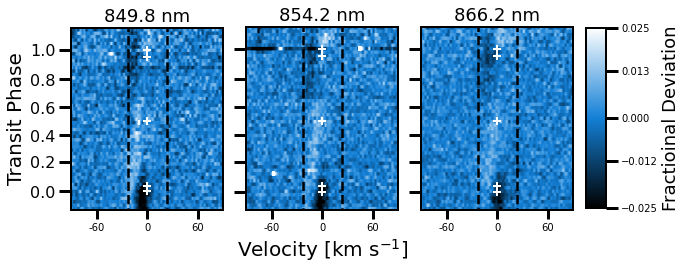

In [28]:
inds = np.arange(0,len(TIME)-6,4)

ratio=1.2
repeat = 5
keys = list(ind_lines.keys())[1:4]


fig, axes = plt.subplots(figsize=(9,5),
                         ncols=len(keys), sharey=True,
                         gridspec_kw={'wspace':0.15,
                                      'hspace':0})
cbar_lim = 0.025

i, x = 0, 0
for ax in axes.reshape(-1):
    
    nw, ns = mask_lines(ind_waves[keys[x]], ind_lines[keys[x]], 
                        std=6, offset=0.01,
                        template_inds=np.where(np.isnan(yphase)==True)[0])

    bins, _ = expanding_bins(ns, repeat=repeat)
    
    repeat_phase = np.zeros(len(yphase)*repeat)
    z = 0
    
    for i in range(len(TIME)):
        repeat_phase[z:z+repeat] = yphase[i]
        z += repeat
    interp_phase = interp1d(repeat_phase, np.arange(0,len(repeat_phase),1,dtype=int), )

    vel, midpoint = to_velocity(nw[0])
    vel = vel.value
    interp = interp1d(vel, np.arange(0,len(vel),1))

    ax.set_title(keys[x], fontsize=20)
    #bins = expanding_bins(lines[x], repeat=4)
    im = ax.imshow(bins, cmap=cm,
                   vmin=-cbar_lim, vmax=cbar_lim)

    if x == 1:
        ax.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)
        ax.set_title('854.2 nm', fontsize=18)
        
    ax.vlines(interp(23), -10, len(bins+30), color='k', lw=2.5, linestyle='--')
    ax.vlines(interp(-23), -10, len(bins)+30, color='k', lw=2.5, linestyle='--')
    
    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(interp_phase(yticks))
    ax.set_yticklabels(yticks, fontsize=16)
    
    for p in [0, ingress_phase, 0.5, egress_phase, 1]:
        ax.plot(interp(0), interp_phase(p), 'w+', ms=8, linewidth=2,
                markeredgecolor='w', markeredgewidth=2)
    
    
    ax.set_ylim(0, len(bins))
    
    xticks = [-60,0,60]
    ax.set_xticks(interp(xticks))
    ax.set_xticklabels(xticks)
    ax.set_xlim(interp(-90), interp(90))
    
    if x == 0:
        ax.set_ylabel('Transit Phase', fontsize=20)
        ax.set_title('849.8 nm', fontsize=18)
    if x == 2:
        ax.set_title('866.2 nm', fontsize=18)
    
    x += 1
    
    
cax = fig.add_axes([0.92, 0.255, 0.03, 0.5])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractioinal Deviation', fontsize=18)
cbar.set_ticks(np.round(np.linspace(-cbar_lim, cbar_lim, 5),3))
#plt.savefig(os.path.join(plot_dir,
#                         'ca_deviations.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

In [261]:
ind_lines['caIII'][:,1:].shape, vel.shape, interp_std['caIII'].shape

((53, 762), (762,), (53, 12774))

In [262]:
params = subregions(lines['wavelength'][3], 
                        wavelengths['caIII'][0],
                        offsets[3], 
                        line_offsets[3], 
                        feature='caIII')

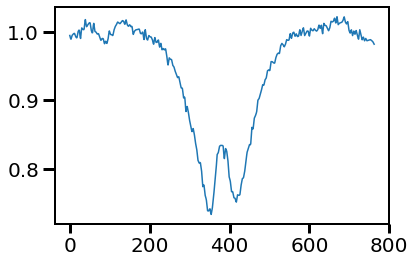

In [263]:
plt.plot(ind_lines['caIII'][0])

847.38 361
853.96 382
864.199 382


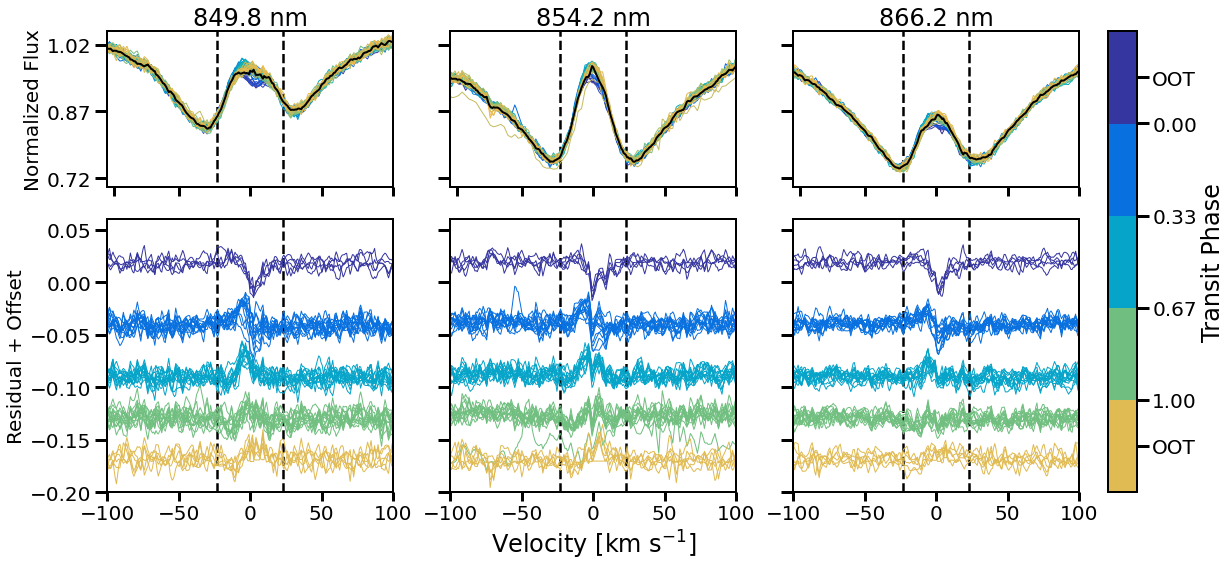

In [264]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import BoundaryNorm

subkeys = ['caI', 'caII', 'caIII']
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3,
                                                      figsize=(20,8),
                                                      gridspec_kw={'height_ratios':[1,1.75]})
top_row = [ax1, ax2, ax3]
bottom_row = [ax4, ax5,ax6]

temp_inds = np.where(np.isnan(yphase)==True)[0]

cmap = mpl.colors.ListedColormap(parula_colors)
bounds = [0, 0.3, 0.6, 1.0]
int_bound = []
for i in range(len(bounds)):
    if i == 0:
        ind = np.where((np.isnan(yphase[:10])==True))
    else:
        ind = np.where((yphase>=bounds[i-1]) & (yphase < bounds[i]))
    int_bound.append(int(np.nanmedian(ind)*4))
last_range = np.where(np.isnan(yphase)==True)[0]
last_range = last_range[last_range>10]
int_bound.append( int(np.nanmedian(last_range)*4))
#int_bound.append(int_bound[-1]+2)

#ax0.axis('off')

for k, key in enumerate(subkeys):
    template = np.nanmedian(ind_lines[key][temp_inds], axis=0)
    template /= np.nanmedian(template[:20])

    if key == 'caI':
        l = 847.38#ind_waves[key][0][145]
    elif key == 'caII':
        l = 853.96#ind_waves[key][0][165]
    else:
        l = 864.199#ind_waves[key][0][168]
        
    vel, midpoint = to_velocity(ind_waves[key][0], line=l)
    print(l, midpoint)
    for i in range(len(ind_lines[key])):
        f = ind_lines[key][i] / np.nanmedian(ind_lines[key][i][:20])

        top_row[k].plot(vel, f, c=parula_colors[i*4], lw=1)
        
        if np.isnan(yphase[i]) == True and i < 10:
            bottom_row[k].plot(vel, f-template+0.02, 
                                c=parula_colors[int_bound[0]], lw=1)
        elif yphase[i]>=0 and yphase[i]<0.33:
             bottom_row[k].plot(vel, f-template-0.04, 
                                c=parula_colors[int_bound[1]], lw=1)
        elif yphase[i]>=0.33 and yphase[i]<0.67:
             bottom_row[k].plot(vel, f-template-0.09, 
                                c=parula_colors[int_bound[2]], lw=1)
        elif yphase[i]>=0.67 and yphase[i]<=1.0:
            bottom_row[k].plot(vel, f-template-0.13, 
                               c=parula_colors[int_bound[3]], lw=1)
        else:
            bottom_row[k].plot(vel, f-template-0.17, 
                               c=parula_colors[int_bound[4]], lw=1)
            
    top_row[k].plot(vel, template, 'k', lw=2)
    
    bottom_row[k].set_xlim(-100,100)
    top_row[k].set_xlim(-100,100)
    
    if k == 0:
        top_row[k].set_title('849.8 nm')
    elif k == 2:
        top_row[k].set_title('866.2 nm')

    top_row[k].set_xticks([-95, -50, 0, 50, 100])
    bottom_row[k].set_xticks([-100, -50, 0, 50, 100])
    
    top_row[k].set_xticklabels([])
    
    top_row[k].vlines(23, -10, 10, color='k', linestyle='--', lw=2.5)
    top_row[k].vlines(-23, -10, 10, color='k', linestyle='--', lw=2.5)
    
    bottom_row[k].vlines(23, -10, 10, color='k', linestyle='--', lw=2.5)
    bottom_row[k].vlines(-23, -10, 10, color='k', linestyle='--', lw=2.5)
    
    if k > 0:
        top_row[k].set_yticklabels([])
        bottom_row[k].set_yticklabels([])
    top_row[k].set_ylim(0.7,1.05)
    top_row[k].set_yticks(np.round(np.linspace(0.72,1.02,3),2))
    bottom_row[k].set_ylim(-0.2,0.06)
    
    if k == 1:
        bottom_row[k].set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)
        top_row[k].set_title('854.2 nm')
bottom_row[0].set_ylabel('Residual + Offset')
top_row[0].set_ylabel('Normalized Flux')

cmap = mpl.colors.ListedColormap(np.flip(parula_colors[int_bound]))
#norm = BoundaryNorm(int_bound, cmap.N)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.02, 0.8])

cbar = ColorbarBase(cax, cmap=cmap)#, 
                    #norm=norm)
cbar.set_ticks([0.1, 0.2, 0.4, 0.6, 0.8, 0.9])
cbar.set_ticklabels(np.flip(['OOT', '0.00', '0.33', '0.67', '1.00', 'OOT']))
cbar.set_label('Transit Phase', fontsize=24)
plt.subplots_adjust(hspace=0.15, wspace=0.2)
#plt.colorbar(cax=cax)


#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'calcium_triplet.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

In [68]:
np.nanmedian(ind_waves['caIII'][0])

864.1985017552689

In [ ]:
np.arange(0,1.2,0.2)

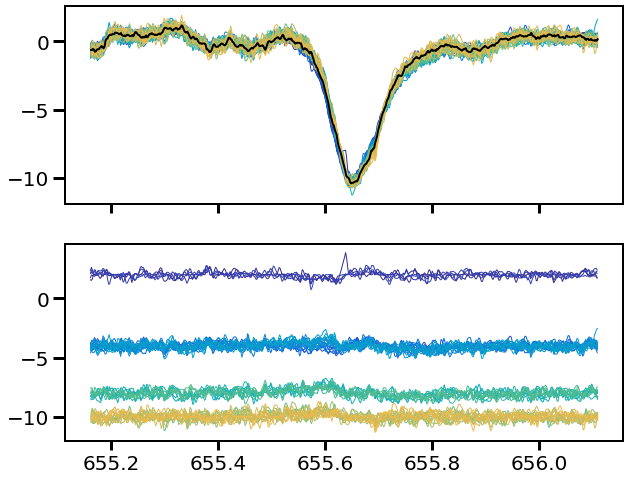

In [75]:
key = 'halpha'
template = np.nanmedian(halpha_normalized[temp_inds], axis=0)
#template /= np.nanmedian(template)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,8), sharex=True)

for i in range(len(halpha_normalized)):
    
    ax1.plot(ind_waves[key][i], halpha_normalized[i], c=parula_colors[i*4], lw=1,
             label=np.round(TIME[i].value,3))
    if i < 5:
        ax2.plot(ind_waves[key][i], halpha_normalized[i]-template+2, 
                 c=parula_colors[i*4], lw=1)
    elif i >= 5 and i <25:
         ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-4, 
                  c=parula_colors[i*4], lw=1)
    elif i >=25 and i < 37:
         ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-8, 
                  c=parula_colors[i*4], lw=1)
    else:
        ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-10, 
                 c=parula_colors[i*4], lw=1)
ax1.plot(ind_waves[key][i], template, 'k', lw=2)
#ax1.set_ylim(0.73,1.1)
#ax2.set_ylim(-0.17,0.07)
#plt.xlim(847.3, 847.5)
#plt.xlim(864., 864.4)


In [76]:
((20*u.km/u.s*857*u.nm)/(3e8*u.m/u.s)).to(u.nm)

<Quantity 0.05713333 nm>

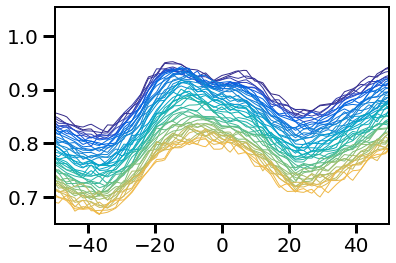

In [77]:
key = 'caI'
for i in range(len(ind_waves[key])):
    vel, _ = to_velocity(ind_waves[key][i])
    f = ind_lines[key][i] / np.nanmedian(ind_lines[key][i])

    plt.plot(vel, f-0.003*i, c=parula_colors[i*4], lw=1)
    plt.xlim(-50,50)

## Measuring RVs

### Marshall's code + RVs

In [266]:
savdir = '/Users/arcticfox/Documents/atmospheres/v1298tau/marshall_plots/planetc'
marshall = readsav(os.path.join(savdir, 'working-dtout.sav'))

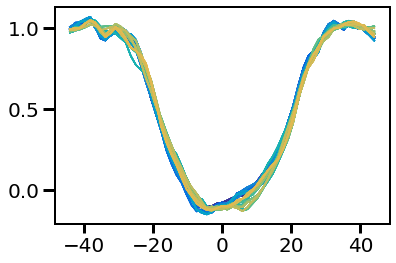

In [267]:
# fit a line to the ends to try and flatten the lines

template = np.nanmedian(marshall['phaseprof'], axis=0)
rvs = np.zeros(len(marshall['phaseprof']))
inds = np.append(np.arange(0,10,1,dtype=int), np.arange(len(marshall['vabsfine'])-10,
                                                        len(marshall['vabsfine']), 1, dtype=int))
for i in range(len(marshall['phaseprof'])):
    fit = np.polyfit(marshall['vabsfine'][inds], 
                     marshall['phaseprof'][i][inds], deg=2)
    model = np.poly1d(fit)
    
    if i < 200:
        plt.plot(marshall['vabsfine'], 
                 marshall['phaseprof'][i]/model(marshall['vabsfine']), 
                 c=parula_colors[i])
    
    rvs[i] = np.nansum( (marshall['phaseprof'][i]-template) * marshall['vabsfine']   )

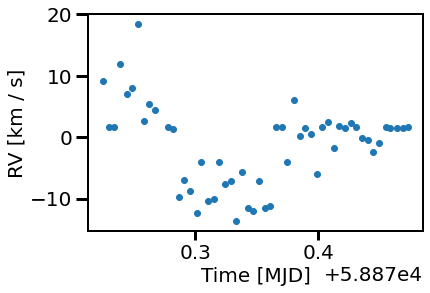

In [268]:
_, args = np.unique(rvs, return_index=True)
args = np.linspace(0, len(rvs)-1, len(TIME), dtype=int)
plt.plot(TIME.value, rvs[args],'o')
plt.xlabel('Time [MJD]')
plt.ylabel('RV [km / s]');
#plt.savefig(os.path.join(plot_dir, 'marshall_rvs.png'),
#            dpi=200, rasterize=True, bbox_inches='tight')

### My lines --> RVs

In [269]:
list(ind_lines.keys())

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2', 'mgb4']

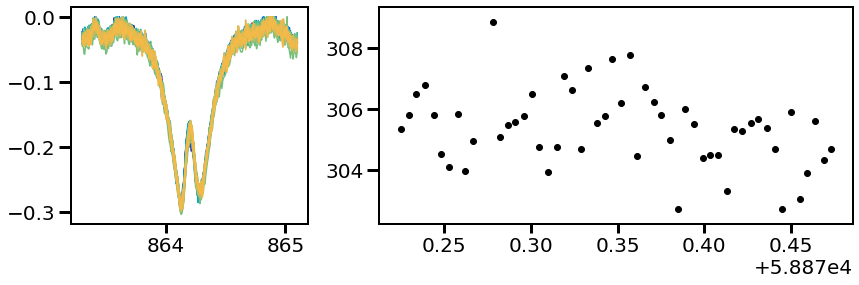

In [270]:
key = 'caIII'

template = np.nanmedian(ind_lines[key], axis=0)

peaks = np.zeros(len(ind_lines[key]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4),
                               gridspec_kw={'width_ratios':[1,2]})
inds = np.append(np.arange(0,25,1,dtype=int), 
                 np.arange(len(ind_waves[key][0])-25,
                           len(ind_waves[key][0]),1,dtype=int))

fit = np.polyfit(ind_waves[key][0][inds], template[inds], deg=11)
model = np.poly1d(fit)
template /= model(ind_waves[key][0])


for i, flux in enumerate(ind_lines[key]):
    fit = np.polyfit(ind_waves[key][i][inds], flux[inds], deg=11)
    model = np.poly1d(fit)
    model = model(ind_waves[key][i])
    
    corr = np.correlate(template - np.nanmedian(template), 
                        flux/model - np.nanmax(flux/model),
                        mode='same')
    
    ax1.plot(ind_waves[key][i], 
             flux-np.nanmax(flux), c=parula_colors[i*4])
    
    c = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)

    
    fit = np.polyfit(c-np.argmax(c), corr[c], deg=2)
    maximum = -fit[1]/(2*fit[0]) # pixel units
    peaks[i] = maximum
    
rvs = np.nanmedian(np.diff(np.log(ind_waves[key][0]))) * 3e8 * peaks
rvs = (rvs * u.m / u.s).to(u.km/u.s)
ax2.plot(TIME.value, rvs,'ko')
ax2.set_ylim(np.nanmin(rvs.value)-0.5, np.nanmax(rvs.value)+0.5);
#plt.ylim(135,145)

# Feature light curves

In [271]:
keys = list(ind_waves.keys())
keys

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2', 'mgb4']

In [272]:
Time(1416.63407+2457000.0, format='jd')#.mjd

<Time object: scale='utc' format='jd' value=2458416.63407>

In [273]:
pieces = {}

for l, key in enumerate(keys[:-1]):
    print(key)
    
    params = subregions(lines['wavelength'][l], 
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)
    
    cont_split = int(np.where(np.diff(params['continuum']) > 1)[0][0])

    red = params['continuum'][cont_split+1:]
    blue = params['continuum'][:cont_split]
    

    for i in range(len(wavelengths[key])):
        
        if i == 0:
            f = np.zeros((len(wavelengths[key]), 
                         len(spectra[key][i][params['region']][params['line']])))
            r = np.zeros((len(wavelengths[key]), len(spectra[key][i][red])))
            b = np.zeros((len(wavelengths[key]), len(spectra[key][i][blue])))
            w = np.zeros((len(wavelengths[key]), 
                         len(interp_std[key][i][params['region']][params['line']])))
            
        f[i] = spectra[key][i][params['region']][params['line']]+0.0
        w[i] = interp_std[key][i][params['region']][params['line']]
        
        r[i] = spectra[key][i][red] + 0.0
        b[i] = spectra[key][i][blue]+ 0.0
        
        #num_val = feat/weight
        #denom_val = 1.0/weight

    pieces[key] = [f, w, r, b]

halpha
caI
caII
caIII
NaD
FeII
Li
mgb2


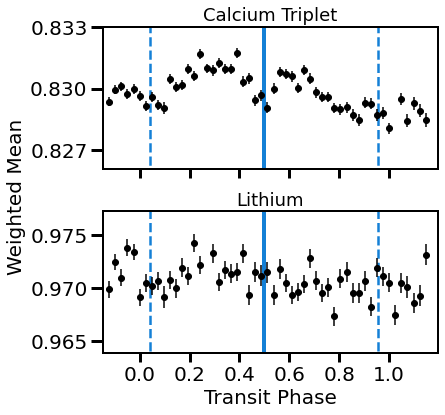

In [274]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6),
                               sharex=True)

interp = interp1d(yphase, np.arange(0,len(yphase),1))

for phase in [ingress_phase, egress_phase, 0.5]:
    if phase != 0.5:
        linestyle='--'
        lw=2.5
    else:
        linestyle='-'
        lw=4
    ax1.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)
    ax2.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)

num, denom = 0, 0
cont, err = 0, np.zeros(len(pieces[key][0]))

key = 'Li'
num = np.nansum(np.array(pieces[key][0]) / np.array(pieces[key][1]**2), axis=1)
denom = np.nansum( 1.0 / np.array(pieces[key][1]**2), axis=1)
err = np.sqrt( 1.0 / np.nansum(pieces[key][1]**-2, axis=1))

#cont = np.nanmean(np.array(pieces[key][2]), axis=1)
#cont += np.nanmean(np.array(pieces[key][3]), axis=1)

flux1 = (num/denom)#/cont
#flux1 /= np.nanmedian(flux1)

#err = np.sqrt(1/np.nansum(interp_variances['Li']**2, axis=1))

ax2.errorbar(np.arange(0,len(flux1),1), 
             flux1, yerr=err,
             color='k', #yerr=err, 
             fmt='o')

ax2.set_title('Lithium', fontsize=18)
ax2.set_ylim(np.nanmin(flux1)+0.009, np.nanmax(flux1)+0.003)


#ax2.set_yticks(np.round(np.arange(np.nanmin(flux1)+0.010, np.nanmax(flux1)+0.003,0.005),3))

canum, cadenom = 0, 0
cont, caerr = 0, 0

for key in ['caI', 'caII', 'caIII']:
    canum   += np.nansum(np.array(pieces[key][0]) / np.array(pieces[key][1]**2), axis=1)
    cadenom += np.nansum( 1.0 / np.array(pieces[key][1]**2), axis=1)
    caerr   += np.nansum(pieces[key][1]**-2, axis=1) 
    
caerr = np.sqrt(1.0/caerr)

flux2 = (canum/cadenom)

ax1.errorbar(np.arange(0,len(flux2),1), 
             flux2, 
             yerr=caerr,
             color='k', #yerr=err, 
             fmt='o')
ax1.set_ylim(np.nanmin(flux2)+0.001, np.nanmax(flux2)+0.001)
ax1.set_yticks(np.round(np.arange(np.nanmin(flux2)+0.002, np.nanmax(flux2)+0.002,0.003),3))
ax1.set_title('Calcium Triplet', fontsize=18)

ax2.set_xlabel('Transit Phase')
ax2.set_ylabel('Weighted Mean', y=1.1, x=-0.4)
    

ax2.set_xticks(interp(np.arange(0,1.2,0.2)))
ax2.set_xticklabels(np.round(np.arange(0,1.2,0.2),2))
ax2.set_xlim(-1, len(yphase)+1)

plt.subplots_adjust(hspace=0.3)

#plt.savefig(os.path.join(plot_dir, 'weighted_means.pdf'),
#            rasterize=True, bbox_inches='tight', dpi=250)

In [275]:
hrtime = ((TIME.value*units.day-TIME.value[0]*units.day)).to(units.hour)

In [100]:
np.save('calcium.npy', [hrtime.value, flux2, err, yphase])

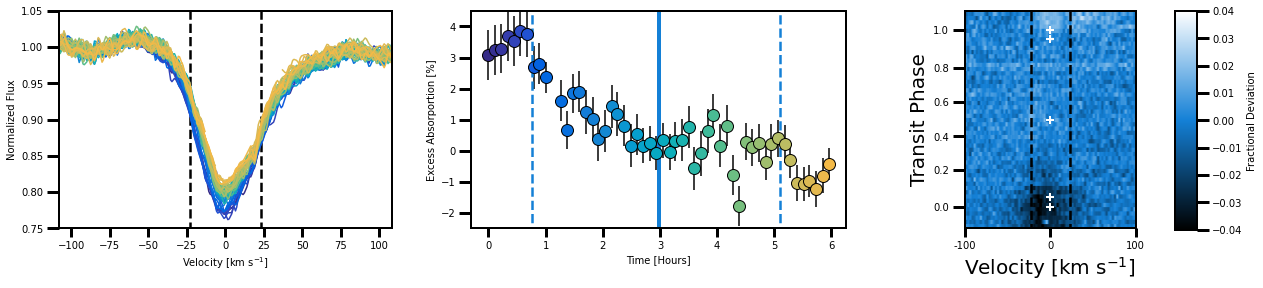

In [29]:
nw, ns = mask_lines(ind_waves['halpha'], ind_lines['halpha'], std=3, offset=0.05)#,
                    #template_inds=np.where(np.isnan(yphase)==True)[0])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,4),
                                    gridspec_kw={'width_ratios':[2,2.25,1.5]})

time_hours = (TIME.value*units.day-np.nanmin(TIME.value)*units.day).to(units.hour)

vel, midpoint = to_velocity(nw[0], line=655.65)
vel = vel.value

err = 1/np.nansum(interp_std['halpha']**2, axis=1)

for i in range(len(ns)):
    ax1.plot(vel, ns[i]/np.nanmedian(ns[i]),  c=parula_colors[i*4])
    ax2.errorbar(time_hours.value[i], widths['halpha'][i], 
                 yerr=err[i],
                 marker='o', ms=12, ecolor='k',
                 c=parula_colors[i*4],
                 markeredgecolor='k')

    
ax1.vlines(23, -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax1.vlines(-23, -100, 1000,
           color='k', linestyle='--', lw=2.5)


interp = interp1d(yphase, time_hours.value)


ax2.vlines(interp(ingress_phase), -100,100,
           color=parula_colors[60], linestyle='--', lw=2.5)
ax2.vlines(interp(egress_phase), -100,100, 
           color=parula_colors[60], linestyle='--', lw=2.5)
ax2.vlines(interp(0.5), -100,100, 
           color=parula_colors[60], linestyle='-', lw=4)


ax2.set_ylim(-2.5,4.5)

ax1.set_xlabel('Velocity [km s$^{-1}$]')
ax1.set_ylim(0.75,1.05)
ax1.set_xlim(-108,108)
ax1.set_ylabel('Normalized Flux')


ax2.set_ylabel('Excess Absorportion [%]')
ax2.set_xlabel('Time [Hours]')

repeat=6
bins, temp = expanding_bins(ind_lines['halpha'], repeat=repeat)
im = ax3.imshow(bins, cmap=cm, vmin=-0.04, vmax=0.04)

repeat_yphase = np.zeros(len(yphase)*repeat)

z = 0
for i in range(len(yphase)):
    repeat_yphase[z:z+repeat] = yphase[i]
    z += repeat

interp = interp1d(repeat_yphase, np.arange(0,len(repeat_yphase),1))
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax3.set_yticks(interp(yticks))
ax3.set_yticklabels(yticks)

interp_vel = interp1d(vel, np.arange(0,len(vel),1))

xticks = [interp_vel(-100), interp_vel(0), interp_vel(100)]
ax3.set_xticks(xticks)
ax3.set_xticklabels([-100,0,100])

for p in [0, ingress_phase, 0.5, egress_phase, 1]:
    ax3.plot(interp_vel(0), interp(p), 'w+', ms=8, linewidth=2,
             markeredgecolor='w', markeredgewidth=2)


ax3.vlines(np.where(vel>=23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax3.vlines(np.where(vel>=-23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
#ax3.hlines(interp(0.5), -100, 1000, color='w',
#           linestyle='--', lw=2.5)


ax3.set_ylim(0,len(bins)-10)
ax3.set_xlim(interp_vel(-100), interp_vel(100))
ax3.set_ylabel('Transit Phase', fontsize=20)
ax3.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)

cax = fig.add_axes([0.9, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation')

plt.subplots_adjust(wspace=0.25)
#plt.savefig(os.path.join(plot_dir, 'halpha.pdf'),
#            dpi=250, rasterize=True,
#            bbox_inches='tight')

In [32]:
plt.rcParams['font.size'] = 16

1.787673599964024

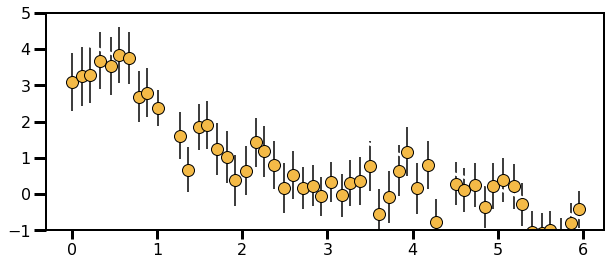

In [53]:
plt.figure(figsize=(10,4))

q = (((time_hours.value <= 0.6) & (time_hours.value>0.5)) 
     | ((time_hours.value > 4.8) & (time_hours.value<5.2) ))
fit = np.polyfit(time_hours.value[q], widths['halpha'][q], 1)
model = np.poly1d(fit)

plt.errorbar(time_hours.value, widths['halpha'], 
                 yerr=err, linestyle='',
                 marker='o', ms=12, ecolor='k',
                 c=parula_colors[i*4],
                 markeredgecolor='k')
plt.plot(time_hours.value, model(time_hours.value), 'w', lw=3)

plt.ylim(-1,5)
model(3)

In [65]:
model(3) - widths['halpha'][time_hours.value>=2.928][0] 

1.8503589259054116

In [102]:
np.save('/Users/arcticfox/Downloads/spectrum277/real_halpha.npy', 
        [widths['halpha'],err])

# EWs for Unocculted Starspots

In [176]:
from astropy.coordinates import SkyCoord, SpectralCoord, EarthLocation
from matplotlib import gridspec

In [136]:
location = EarthLocation.of_site('gemini_north')
gemini = location.get_itrs(TIME)
vtau = SkyCoord('04h05m19.6s  +20d09m25.6', frame='icrs', 
                distance=108.5*u.pc,
                radial_velocity=14.427*u.km/u.s)

In [153]:
l = np.zeros(ind_waves['caI'].shape)
for i in range(len(ind_waves['caI'])):
    sc_vtau = SpectralCoord(ind_waves['caI'][i] * u.nm,
                            observer=gemini[i], target=vtau)
    l[i] = sc_vtau.with_observer_stationary_relative_to(sc_vtau.target)

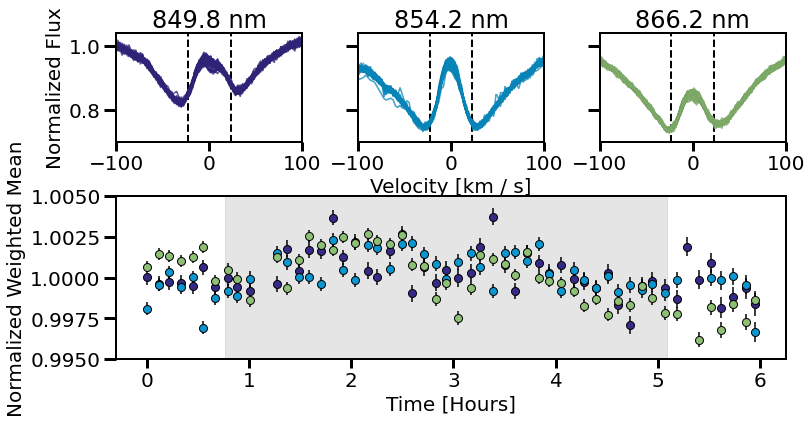

In [295]:
fig2 = plt.figure(constrained_layout=True, figsize=(12,6))
spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig2, height_ratios=[1,1.5])
ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1])
ax3 = fig2.add_subplot(spec2[0, 2])
ax4 = fig2.add_subplot(spec2[1, :])


short = [ax1, ax2, ax3]
colors = [parula_colors[0], parula_colors[80], parula_colors[160]]

keys = ['caI', 'caII', 'caIII']
masks = [np.where((ind_waves[keys[0]][0] > 846.95) & (ind_waves[keys[0]][0] < 847.7))[0],
         np.where((ind_waves[keys[1]][0] > 853.5) & (ind_waves[keys[1]][0] < 854.4))[0],
         np.where((ind_waves[keys[2]][0] > 863.85) & (ind_waves[keys[2]][0] < 864.55))[0],
        ]
templates = [np.nanmedian(ind_lines[keys[0]], axis=0)[masks[0]],
             np.nanmedian(ind_lines[keys[1]], axis=0)[masks[1]],
             np.nanmedian(ind_lines[keys[2]], axis=0)[masks[2]],
            ]
titles = ['849.8 nm', '854.2 nm', '866.2 nm']

x = 0
for x in range(len(short)):
    ews = np.zeros(len(TIME))
    
    if x==0:
        l = 847.38
    elif x==1:
        l = 853.96
    else:
        l = 864.199
        
    vel, midpoint = to_velocity(ind_waves[keys[x]][0], line=l)
    
    num   = np.nansum(np.array(pieces[keys[x]][0]) / np.array(pieces[keys[x]][1]**2), axis=1)
    denom = np.nansum( 1.0 / np.array(pieces[keys[x]][1]**2), axis=1)
    err   = np.nansum(pieces[keys[x]][1]**-2, axis=1) 
    
    err = np.sqrt(1.0/err)

    flux2 = (num/denom)

    ax4.errorbar(time_hours.value, 
                 flux2/np.nanmedian(flux2), 
                 yerr=err, ms=8,
                 color=colors[x], #yerr=err, 
                 fmt='o', ecolor='k', markeredgecolor='k')
    
    for i in range(len(ind_lines[keys[x]])):

        short[x].plot(vel, ind_lines[keys[x]][i], 'k', alpha=0.2)
        short[x].plot(vel[masks[x]], 
                      ind_lines[keys[x]][i][masks[x]], 
                      c=colors[x], alpha=0.7)
        
        ews[i] = np.nansum( (ind_lines[keys[x]][i][masks[x]]/templates[x]) -1 )*-1
        
   # ax4.plot(time_hours, ews, ms=10, c=colors[x], marker='o')
    short[x].vlines(-23, 0, 2, 'k', linestyle='--', lw=2)
    short[x].vlines(23, 0, 2, 'k', linestyle='--', lw=2)
    short[x].set_xlim(-100,100)
    short[x].set_ylim(0.7,1.04)
    if x > 0:
        short[x].set_yticklabels([])

    short[x].set_title(titles[x])
    
interp = interp1d(yphase, time_hours.value)


ax4.axvspan(interp(ingress_phase), interp(egress_phase),
           color='k', alpha=0.1)

#ax4.errorbar(time_hours.value, flux2/np.nanmedian(flux2), 
#             yerr=caerr, marker='o', color='k', linestyle='')
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)
ax2.set_xlabel('Velocity [km / s]')
ax4.set_ylim(0.995,1.005)

ax4.set_ylabel('Normalized Weighted Mean')
ax4.set_xlabel('Time [Hours]')
ax1.set_ylabel('Normalized Flux')
plt.savefig('/Users/arcticfox/Desktop/calcium_ew.png', dpi=250, rasterize=True,
           bbox_inches='tight')

In [ ]:
# overall spot distribution archival Hubble transmission spectroscopy data?
# think through if we can build a story that explains variation in line core 
#     and variation in calcium depth in terms of spots
#     Paparazzi??

# Putting in context

In [305]:
from astropy.table import Table, Column
from matplotlib.colors import LogNorm
from scipy.stats import kde
from matplotlib import patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [306]:
tab = Table.read('reformatted_berger20.tab', format='ascii')
archive = Table.read('PS_2021.04.12_15.02.29.csv', format='csv')

In [307]:
x = archive[archive['st_age']>1]['pl_orbper']+0.0
y = archive[archive['st_age']>1]['pl_rade']+0.0

x = np.log10(x)
y = np.log10(y)

# NUMBER OF BINS TO DIVIDE INTO
nbins=150
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = k(np.vstack([xi.flatten(), yi.flatten()]))

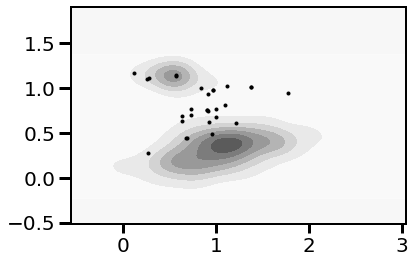

In [308]:
fig, ax = plt.subplots()
ax.contourf(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Greys')
p = patches.Rectangle((np.log10(0.015), np.log10(0.6)), 
                      height=1.6,
                      width=24, color='w', alpha=0.3,
                      zorder=1)

plt.plot(np.log10(archive[archive['st_age']<0.2]['pl_orbper']),
         np.log10(archive[archive['st_age']<0.2]['pl_rade']), 
         'k.')


plt.xlim(np.nanmin(xi), np.nanmax(xi))
plt.ylim(np.nanmin(yi), np.nanmax(yi))
ax.add_patch(p)

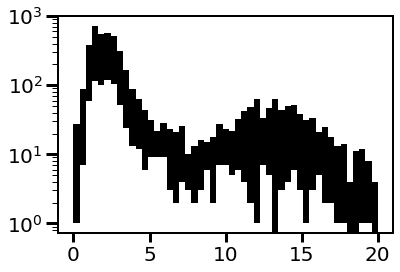

In [309]:
bins = np.linspace(0,20,50)
plt.hist(archive[archive['st_age']>=1]['pl_rade'], bins=bins, color='k')
plt.hist(archive[archive['st_age']<1]['pl_rade'], bins=bins, color='w')
plt.yscale('log');

4970.0
--
--
--


(-0.5, 1.9)

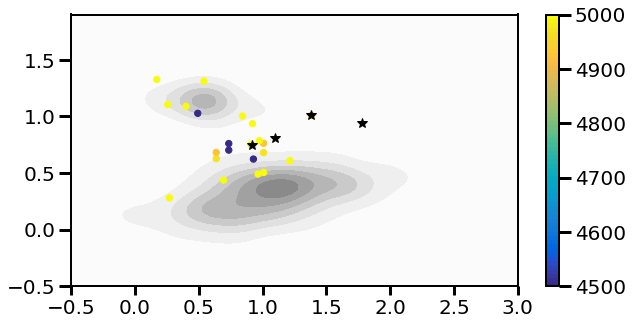

In [316]:
parula = ListedColormap(np.load('/Users/arcticfox/parula_data.npy'))


x = archive[archive['st_age']>1]['pl_orbper']+0.0
y = archive[archive['st_age']>1]['pl_rade']+0.0

x = np.log10(x)
y = np.log10(y)

# NUMBER OF BINS TO DIVIDE INTO
nbins=150
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = k(np.vstack([xi.flatten(), yi.flatten()]))

fig, ax = plt.subplots(figsize=(10,5))

plt.contourf(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Greys')
p = patches.Rectangle((np.log10(0.0015), np.log10(0.09)), 
                      height=3,
                      width=24, color='w', alpha=0.5,
                      zorder=1)
ax.add_patch(p)

young_tab = archive[archive['st_age']<0.4]
young_tab = young_tab[young_tab['st_age']>young_tab['st_ageerr1']]

logper = np.log10(young_tab['pl_orbper'])
lograde = np.log10(young_tab['pl_rade'])

plt.scatter(logper, lograde, 
            c=young_tab['st_teff'], 
            s=40, cmap=parula,
            zorder=3, vmin=4500, vmax=5000)

keys = [i for i in young_tab['pl_name'] if 'V1298 Tau' in i]
keys = np.unique(keys)
for key in keys:
    i = np.where(young_tab['pl_name']==key)[0][0]
    print(young_tab['st_teff'][i])

    plt.plot(logper[i], lograde[i], 'k*', zorder=10, ms=10)

plt.colorbar()
plt.xlim(-0.5,3)
plt.ylim(-0.5,1.9)

In [320]:
young_tab.sort('st_teff')
young_tab[(young_tab['st_teff']>4500) & (young_tab['st_teff']<5000)]

pl_name,discoverymethod,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_rad,st_raderr1,st_raderr2,st_radlim,st_mass,st_masserr1,st_masserr2,st_masslim,st_age,st_ageerr1,st_ageerr2,st_agelim,sy_dist,sy_disterr1,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2
str16,str25,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
TOI-942 c,Transit,0,10.15643,6.9e-05,-7.9e-05,0,0.0847,0.0012,-0.0011,0,5.79,0.19,-0.18,0,--,--,--,--,--,--,--,--,4928.0,125.0,-85.0,0,1.02,0.02,-0.02,0,0.79,0.04,-0.03,0,0.09,0.07,-0.07,0,152.601,0.695,-0.689,11.982,0.026,-0.026,9.639,0.023,-0.023
TOI-942 b,Transit,0,4.32419,3e-05,-3e-05,0,0.04796,0.00073,-0.00065,0,4.81,0.2,-0.2,0,--,--,--,--,--,--,--,--,4928.0,125.0,-85.0,0,1.02,0.02,-0.02,0,0.79,0.04,-0.03,0,0.09,0.07,-0.07,0,152.601,0.695,-0.689,11.982,0.026,-0.026,9.639,0.023,-0.023
TOI-942 b,Transit,0,4.3263,0.0011,-0.0011,0,0.0498,0.0007,-0.0007,0,4.242,0.376,-0.313,0,--,--,--,--,--,--,--,--,4969.0,100.0,-100.0,0,0.89,0.07,-0.05,0,0.88,0.04,-0.04,0,0.05,0.03,-0.02,0,152.601,0.695,-0.689,11.982,0.026,-0.026,9.639,0.023,-0.023
TOI-942 c,Transit,0,10.1605,0.0056,-0.0053,0,0.088,0.0014,-0.0014,0,4.793,0.41,-0.351,0,--,--,--,--,--,--,--,--,4969.0,100.0,-100.0,0,0.89,0.07,-0.05,0,0.88,0.04,-0.04,0,0.05,0.03,-0.02,0,152.601,0.695,-0.689,11.982,0.026,-0.026,9.639,0.023,-0.023
V1298 Tau b,Transit,0,24.13861,0.00102,-0.0009,0,0.1687,0.0025,-0.0026,0,10.22,0.55,-0.59,0,33.2,4.5,-4.2,0,668,22,-22,0,4970.0,120.0,-120.0,0,1.31,0.05,-0.06,0,1.1,0.05,-0.05,0,0.023,0.004,-0.004,0,108.199,0.704,-0.696,10.115,0.009,-0.009,8.094,0.021,-0.021


In [326]:
archive[((archive['st_age']<1) & (archive['st_teff']>4500) & 
         (archive['st_teff']<5000) & (archive['st_age']>0.25) 
         & (archive['pl_rade']<10))]['pl_name', 'pl_rade', 'st_age', 'st_teff']

pl_name,pl_rade,st_age,st_teff
str16,float64,float64,float64
K2-233 b,1.398,0.36,4950.0
K2-233 c,1.335,0.36,4950.0
K2-233 d,2.64,0.36,4950.0
WASP-132 b,9.752,0.5,4775.0
WASP-59 b,8.687,0.5,4650.0
K2-101 b,2.0,0.79,4819.0
K2-102 b,1.3,0.79,4695.0
HAT-P-20 b,9.75,0.8,4600.0
Kepler-239 b,2.25,0.8,4941.0


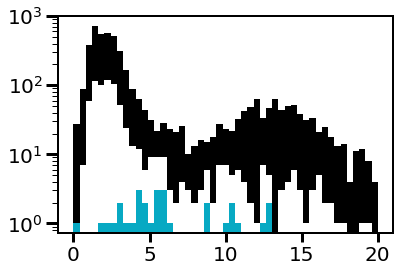

In [818]:
bins = np.linspace(0,20,50)
plt.hist(archive[archive['st_age']>=1]['pl_rade'], bins=bins, color='k')
plt.hist(archive[archive['st_age']<1]['pl_rade'], bins=bins, color='w')
plt.hist(young_tab['pl_rade'], bins=bins, color=parula_colors[100])

plt.yscale('log');

In [ ]:
constants.k

In [67]:
def feature_amp(rp, M, Teq, n, Rs, mu=None):
    if mu == None:
        mu = constants.m_p
        
    g = constants.G * M / rp**2
    g = g.to(units.m / units.s**2)
    H = (constants.k_B * Teq) / (mu * g)
    H = H.to(units.km)
    
    term1 = (rp +n*H)**2 / Rs**2
    term2 = rp**2 / Rs**2
    return (term1 - term2).to(units.Rsun**2/units.Rsun**2), H

mupp = 120 * units.Mearth
rp  = 6.41 * units.Rearth
rs  = 1.345 * units.Rsun
teq = 845 * units.K

In [141]:
n = np.arange(1, 1000, 1)
feature, H = feature_amp(rp, mupp, teq, n, rs)

In [142]:
feature[feature<=0.05][-1], n[feature<=0.05][-1]

(<Quantity 0.04988936>, 706)

In [143]:
n[feature<=0.05][-1]*H

<Quantity 172078.51073318 km>

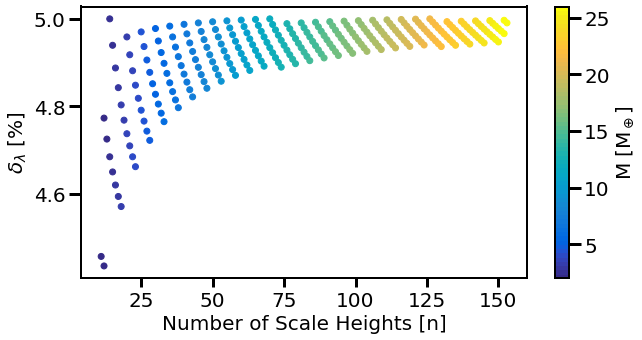

In [223]:
x = 256

masses = np.linspace(2,26,x)
closest_n = np.zeros(x)
closest_f = np.zeros(x)


for i,m in enumerate(masses):
    feature, H = feature_amp(rp, m*units.Mearth, teq, n, rs)
    closest_n[i] = n[feature<=0.05][-1]
    closest_f[i] = feature[feature<=0.05][-1]

plt.figure(figsize=(10,5))
plt.scatter(closest_n, closest_f*100, c=masses, cmap=parula)
plt.xlabel('Number of Scale Heights [n]')
plt.ylabel(r'$\delta_\lambda$ [%]')
plt.colorbar(label=r'M [M$_\oplus$]')
plt.savefig('/Users/arcticfox/Desktop/test.png')


In [68]:
atm_height = np.sqrt(0.05 * rs**2).to(units.Rjup) # = rp**2/rs**2
atm_tail   = (2.5/5.59 * rs).to(units.Rjup)

In [69]:
atm_height, atm_tail

(<Quantity 2.92665711 jupiterRad>, <Quantity 5.85349217 jupiterRad>)

In [73]:
rp

<Quantity 6.41 earthRad>

In [75]:
 np.sqrt(0.0185 * rs**2).to(units.Rearth) / rp

<Quantity 3.11301202>

# Making MISTTBORN file

In [334]:
import pickle

In [335]:
Time(TIME, format='mjd').mjd

array([58870.225, 58870.23 , 58870.234, 58870.239, 58870.244, 58870.248,
       58870.253, 58870.258, 58870.262, 58870.267, 58870.278, 58870.282,
       58870.287, 58870.291, 58870.296, 58870.301, 58870.305, 58870.31 ,
       58870.315, 58870.319, 58870.324, 58870.329, 58870.333, 58870.338,
       58870.343, 58870.347, 58870.352, 58870.357, 58870.361, 58870.366,
       58870.371, 58870.375, 58870.38 , 58870.385, 58870.389, 58870.394,
       58870.399, 58870.403, 58870.408, 58870.413, 58870.417, 58870.422,
       58870.427, 58870.431, 58870.436, 58870.441, 58870.445, 58870.45 ,
       58870.455, 58870.459, 58870.464, 58870.469, 58870.473])

In [337]:
key = 'caIII'
output_dict = {}
output_dict['ttime'] = Time(TIME, format='mjd').mjd
output_dict['texptime'] = np.full(len(TIME), 360.0)
vel = to_velocity(ind_waves[key][0])
output_dict['vabsfine'] = vel[0].value
output_dict['profarr'] = ind_lines[key][:,1:]
output_dict['avgprof'] = np.nanmedian(ind_lines[key][np.isnan(yphase)==True], axis=0)[1:]
output_dict['profarrerr'] = interp_std[key][:,all_params[key]['region']]
output_dict['avgproferr'] = np.nanmean(interp_std[key][:,all_params[key]['region']][np.isnan(yphase)==True], axis=0)/np.sqrt(len(TIME))
output_dict['whichplanet'] = 1

pkl_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn'
with open(os.path.join(pkl_dir,'v1298_{0}.pkl'.format(key)), 'wb') as f:
    pickle.dump(output_dict, f)